In [39]:
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import glob
import numpy as np
import pandas as pd
import cv2
import ast
import glob
from matplotlib import pyplot as plt

In [40]:
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Conv2D, Add, Dot, Lambda, Conv2DTranspose, Dot, Activation, Reshape, BatchNormalization, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Multiply, Softmax, LeakyReLU, Flatten, MaxPool2D, MaxPool3D, Embedding, GRU
from tensorflow.keras.layers import Convolution2D, UpSampling2D, SeparableConv2D, UpSampling3D
from tensorflow.keras.layers import PReLU, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

In [50]:
import tensorflow.keras as keras
import tensorflow as tf

In [ ]:
import nltk
nltk.download('punkt')

In [55]:
print('GPU is available: ', tf.test.is_gpu_available())

1.13.1
False


In [37]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('data_percentage', type=float)
args = parser.parse_args()
data_percentage = args.data_percentage


usage: ipykernel_launcher.py [-h] data_percentage
ipykernel_launcher.py: error: argument data_percentage: invalid float value: '/Users/kevin/Library/Jupyter/runtime/kernel-5d20717d-9c87-41ad-aad6-5041a6564c7b.json'


SystemExit: 2

/Users/kevin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [42]:
# load all captions
captions = pd.read_csv('/coco2017/results/coco-captions-with-categories.csv')
sample_count = round(data_percentage * len(captions.values))
annot_list = captions.values[:sample_count]
data = [] 
corpus_dict = {}
# iterate through each caption 
max_sequence_length = float("-inf")
for row in annot_list: 
      
    captions = row[1].split('|')[:5]
    
    for caption in captions:
        temp = []
        #tokenize the captions into words 
        for j in word_tokenize(caption): 
            temp.append(j.lower()) 
            corpus_dict[j.lower()] = 0
        if len(temp) > max_sequence_length:
            max_sequence_length = len(temp)
        data.append(temp) 

for index, word in enumerate(corpus_dict.keys()):
    corpus_dict[word] = index + 1
    
corpus_size = len(corpus_dict.keys())

FileNotFoundError: [Errno 2] File b'/coco2017/results/coco-captions-with-categories.csv' does not exist: b'/coco2017/results/coco-captions-with-categories.csv'

In [ ]:
# load external text embedding model (word2vec)
w2v_model = Word2Vec.load('/coco2017/resources/text_encoding_ac.bin')

In [ ]:
# encode all our captions
captions_X = []
caption_strings = []

for row in annot_list[:sample_count]:
    captions = row[1].split('|')[:1]
    captions_list = []
    captions_X_list = []
    for caption in captions:
        caption_conv = []
#         print(caption)
        for word in word_tokenize(caption.lower()):
            caption_conv.append(w2v_model[word])
        captions_X_list.append(np.array(caption_conv))
        captions_list.append(caption.lower())
    captions_X.append(captions_X_list)
    caption_strings.append(captions_list)

In [ ]:
# Pad with 0-vectors to max_sequence_length
for i in range(len(captions_X)):
    for j in range(len(captions_X[i])):
        captions_X[i][j].resize((max_sequence_length, 100), refcheck=False)
captions_X = np.array(captions_X)

In [ ]:
# Used to create the random distribution at training time
dist_mean = np.mean(captions_X)
dist_std = np.std(captions_X)
print(dist_mean, dist_std)

In [ ]:
captions_X = np.reshape(captions_X, (sample_count, max_sequence_length, 100))

In [ ]:

def data_loader(file_path):
    '''
    Loads and normalizes all image files in the directory file_path.
    Returns np.array of normalized image matrices.
    '''
    img_paths = glob.glob(file_path + '/*')
    data = []
    for img_path in img_paths:
        data.append(cv2.imread(img_path) / 255.0)
    return np.array(data)

In [ ]:
# loads in data and subsets it to the first 1600 samples
# img_paths = glob.glob('./cleaned-data/00000000[0-9]*.jpg')
# training_imgs_num = len(img_paths)
# print(f'loaded a total of {training_imgs_num} imgs')
imgs_all = data_loader('/coco2017/cleaned-data/')
imgs_y = imgs_all[:sample_count]


In [ ]:
print(caption_strings[0])
# plt.imshow(imgs_y[0])
print(len(caption_strings))
print(len(captions_X))
print(len(imgs_y))

In [ ]:
# custom metric to avoid binary accuracy rounding
import keras.metrics
def image_closeness(y_pred, y_true):
    return K.mean(1 - K.abs(y_pred - y_true), axis=-1)
keras.metrics.image_closeness = image_closeness




In [ ]:
# load autoencoder and get decoder portion
autoencoder = load_model('/coco2017/resources/autoencoder-v2-9k-epochs.h5') # transpose conv
decoder = autoencoder.layers[2]

In [ ]:
# freeze decoder weights
# for layer in decoder.layers:
#     layer.trainable = False
# decoder.trainable = False

In [ ]:
#bounding intermediate model outputs might yield better results
def build_intermediate_model(input_shape, name='textencoder', encode_channels=[4, 8, 16, 32, 32]):
    '''
    Builds textual encoding model. This model's input is textual word2vec embedded vectors and outputs latent image size vectors.
    '''
    embedding_size = 64
    gru_size = 1024
    input_length = input_shape[0]
    input_layer = Input(shape=input_shape)
    
    
    embedded_seq, state_i = GRU(gru_size, return_state=True, name='gru')(input_layer)
    state_i = Dense(1024)(state_i)
    state_i = LeakyReLU()(state_i)

    
        
 
    encoder_block = Reshape((32, 32, 1))(state_i)
    
    for index, channel in enumerate(encode_channels):
        
        shortcut = Conv2D(channel, 3, padding='same', trainable=False)(encoder_block)
        encoder_block = BatchNormalization()(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)    
        
        encoder_block = BatchNormalization()(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)
        
        
        encoder_block = Add()([encoder_block, shortcut])
        
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)

    output_layer = encoder_block
    return Model(input_layer, output_layer, name=name)

In [ ]:
model_intermediate = build_intermediate_model((max_sequence_length, 100))
model_intermediate.summary()

In [ ]:
num_layers = len(model_intermediate.layers)
print(f'Model is {num_layers} layers deep.')

In [ ]:
# Image to latent model
# input: (128,128,3)
# output: (32,32,32)

def build_image_to_latent_model(input_shape, name='image-to-latent', conv_filters=[8,16, 32, 64]):
    input_layer = Input(shape=input_shape)
    
    
    for index, channel in enumerate(conv_filters):
        
        encoder_block = BatchNormalization()(input_layer if index == 0 else encoder_block)
        encoder_block = LeakyReLU()(encoder_block)
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)    
        
        encoder_block = BatchNormalization()(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)
        
        
        
        encoder_block = Conv2D(channel, 3, padding='same', strides=2)(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)
        
    encoder_block = Conv2D(conv_filters[0], 3, padding='same', strides=1)(encoder_block)
    encoder_block = LeakyReLU()(encoder_block)
    output_layer = encoder_block
    
    
    return Model(input_layer, output_layer, name=name)
image_to_latent = build_image_to_latent_model((128,128,3), conv_filters=[16, 32])
image_to_latent.summary()


In [ ]:
# latent to labels model
# input: (32,32,32)
# output: (12)

def build_latent_to_labels_model(input_shape):
    input_latent = Input(shape=input_shape)
    x = Flatten()(input_latent)  

    
    x = Dense(32)(x)
    x = LeakyReLU()(x)
    
    x = Dense(32)(x)
    x = LeakyReLU()(x)
    
    x = Dense(16)(x)
    x = LeakyReLU()(x)
    
    x = Dense(12, activation='softmax')(x)
    
    return Model(input_latent, x, name="latent-to-labels")

latent_to_labels = build_latent_to_labels_model((32,32,48))
latent_to_labels.summary()    



In [ ]:
def build_combined_model():
    '''
    Builds combined generator model. 
    '''
    input_caption = Input(shape=(max_sequence_length, 100))
    latent_representation = model_intermediate(input_caption)
    
    decoded_img = decoder(latent_representation)
    
    submodel_latent = image_to_latent(decoded_img)
    submodel_latent = Concatenate()([submodel_latent, latent_representation])
    labels_out = latent_to_labels(submodel_latent)
    combined_model = Model(input_caption, [decoded_img, labels_out], name="text2img")
    return combined_model

In [ ]:
model_text2img = build_combined_model()

In [ ]:
# model_text2img.summary()

In [ ]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import textwrap

def caption_encoding(string):
    '''
    Returns encoded caption vector from string.
    '''
    caption_conv = []
    for word in word_tokenize(string.lower()):
        caption_conv.append(w2v_model[word])
    caption_conv = np.array(caption_conv)
    caption_conv.resize((max_sequence_length, 100))
    return caption_conv

def rgb_imshow(img, name):
    '''
    Shows bgr opencv image in rgb.
    '''
    plt.xticks([])
    plt.yticks([])
    if name is not None:
        plt.title('\n'.join(textwrap.wrap(name, 20)), fontsize=8)
    else:
        plt.title(name)
    plt.imshow(cv2.cvtColor((img).astype(np.float32), cv2.COLOR_BGR2RGB))

def show_converted(model, caption, noise_ratio=0.1, is_embedded=False):
    '''
    Sample from generative model using the noise ratio.
    '''
    figure(num=None, dpi=100, facecolor='w', edgecolor='k')
    
    caption_input = None
    if not is_embedded:
        caption_input = caption_encoding(caption) + noise_ratio * np.random.normal(dist_std, dist_std, (max_sequence_length, 100))
    else:
        caption_input = caption + noise_ratio * np.random.normal(dist_std, dist_std, (max_sequence_length, 100))

    decoded_img  = model.predict(np.array([caption_input]), steps=None)[0]
    print(np.shape(decoded_img))
    rgb_imshow(np.reshape(decoded_img, (128,128,3)), caption)
    plt.tight_layout()
    plt.show()



In [ ]:
def plot_history(history):
    '''
    Used to plot history after training.
    '''
    plt.plot(history.history['acc'])
    plt.title("Accuracy")
    plt.show()
    plt.plot(history.history['loss'])
    plt.title("Loss")
    plt.show()

In [ ]:
def build_discriminator(conv_channels=[8, 16, 32], dropout=False, residual=False, concat_captions=False):
    if concat_captions:
        text_input = Input(shape=(max_sequence_length, 100))
    image_input = Input(shape=(128, 128, 3))

    if concat_captions:
        text_attn = Flatten()(text_input)

    dropout_rate = 0.5

    for index, channel in enumerate(conv_channels):
        if residual:
            shortcut = Conv2D(channel, 3, padding='same', trainable=False)(image_input if index == 0 else discriminator_block)
        discriminator_block = BatchNormalization()(image_input if index == 0 else discriminator_block)
        discriminator_block = LeakyReLU()(discriminator_block)
        discriminator_block = Conv2D(channel, 3, padding='same')(discriminator_block)
        if dropout:
            discriminator_block = Dropout(dropout_rate)(discriminator_block)

        discriminator_block = BatchNormalization()(discriminator_block)
        discriminator_block = LeakyReLU()(discriminator_block)
        discriminator_block = Conv2D(channel, 3, padding='same')(discriminator_block)
        if dropout:
            discriminator_block = Dropout(dropout_rate)(discriminator_block)
        if residual:
            discriminator_block = Add()([discriminator_block, shortcut])

        discriminator_block = Conv2D(channel, 3, padding='same', strides=2)(discriminator_block)
        discriminator_block = LeakyReLU()(discriminator_block)
        if dropout:
            discriminator_block = Dropout(dropout_rate)(discriminator_block)


    discriminator_block = Flatten()(discriminator_block)
    if concat_captions:
        discriminator_block = Concatenate()([discriminator_block, text_attn])

    dense = Dense(1, activation='sigmoid')(discriminator_block) #change to concatted if add text back

    return Model(image_input, dense, name='Discriminator') #Model([text_input, image_input], dense, name='Discriminator')


In [ ]:
def build_gan():
    '''
    Builds generative adversarial model for training.
    '''
    input_caption = Input(shape=(max_sequence_length, 100))
    input_image = Input(shape=(128, 128, 3))
    generated_image, generated_labels = model_text2img(input_caption)
    discriminator_output = discriminator(generated_image) #discriminator([input_caption, generated_image])
    

    gan = Model(input_caption, [discriminator_output, generated_image, generated_labels])
    return gan

In [ ]:
#logic to train descriminator in adversarial model
model_intermediate = build_intermediate_model((max_sequence_length, 100))
model_text2img = build_combined_model()
discriminator = build_discriminator(conv_channels=[4, 8, 16, 32, 64], dropout=True)
d_adam = Adam(lr=0.00001, beta_1=0.0, beta_2=0.999)
discriminator.compile(optimizer=d_adam, loss='binary_crossentropy', metrics=['binary_accuracy'])
discriminator.trainable = False
adversarial_net = build_gan()
g_adam = Adam(lr=0.0001, beta_1=0.0, beta_2=0.999)
adversarial_net.compile(optimizer=g_adam, loss=['binary_crossentropy', 'mse', 'binary_crossentropy'], loss_weights=[1, 10, 0.1], metrics=['binary_accuracy'])

In [ ]:
superclass_y = []
for row in annot_list[:sample_count]:
    superclass_y.append(ast.literal_eval(row[3]))

In [ ]:
superclass_y = np.array(superclass_y)

In [ ]:
d_loss_means = []
d_acc_means = []
a_loss_means = []
t_loss_means = []
classes_loss_means = []

In [ ]:
# from keras.utils.generic_utils import Progbar
from time import time



# custom adversarial training logic
BATCHSIZE = 32
EPOCHS = 100
for epoch in range(EPOCHS):
    num_data_pts = len(captions_X)
    np.random.seed(epoch)
    np.random.shuffle(captions_X)
    np.random.seed(epoch)
    np.random.shuffle(imgs_y)
    np.random.seed(epoch)
    np.random.shuffle(caption_strings)

    d_hist_loss = []
    d_hist_acc = []
    a_hist_loss = []
    t_hist_loss = []
    classes_hist_loss = []
    print()
    print("epoch {} of {}".format(epoch+1, EPOCHS))
    num_batches = int(num_data_pts // BATCHSIZE)
    #print("number of batches: {}".format(int(X.shape[0] // (BATCHSIZE))))
#     progress_bar = Progbar(target=int(num_data_pts // (BATCHSIZE)))
    minibatches_size = BATCHSIZE
    start_time = time()
    
    for index in range(int(num_data_pts // (BATCHSIZE))):
#         progress_bar.update(index)
        
        #print(f'{BATCHSIZE*index}:{(BATCHSIZE*(index+1))}')
        images_real = imgs_y[BATCHSIZE*index:(BATCHSIZE*(index+1))]
        captions_batch = captions_X[BATCHSIZE*index:(BATCHSIZE*(index+1))] + 0.1 * np.random.normal(dist_std, dist_std, (BATCHSIZE, max_sequence_length, 100))
        labels_fake = np.zeros([BATCHSIZE,1], dtype=np.float32)
        labels_real = np.ones([BATCHSIZE,1], dtype=np.float32)        
        superclass_real = superclass_y[BATCHSIZE*index:(BATCHSIZE*(index+1))]
        
        images_fake, classes_out = model_text2img.predict(captions_batch)
        

        
        train_imgs = np.concatenate((images_real, images_fake))
        train_captions = np.concatenate((captions_batch, captions_batch))
        train_labels = np.concatenate((labels_real, labels_fake))
        

 
        np.random.seed(index)
        np.random.shuffle(train_imgs)
        np.random.seed(index)
        np.random.shuffle(train_captions)
        np.random.seed(index)
        np.random.shuffle(train_labels)
        
        # train discrimiator every 20th epoch
        if index % 20 == 0:
            d_loss, d_acc = discriminator.train_on_batch(train_imgs, train_labels)
            d_hist_loss.append(d_loss)
            d_hist_acc.append(d_acc)

            
        a_loss_1, _, t_loss, t_loss_class, _, t_acc, classes_acc = adversarial_net.train_on_batch(captions_batch, [labels_real, images_real, superclass_real])
        a_hist_loss.append(a_loss_1)
        t_hist_loss.append(t_loss)
        classes_hist_loss.append(t_loss_class)
        #
# ['loss',
#  'Discriminator_loss',
#  'text2img_loss',
#  'text2img_loss',
#  'Discriminator_binary_accuracy',
#  'text2img_binary_accuracy',
#  'text2img_binary_accuracy_1']
        #
        #

    classes_loss_means.append(np.mean(t_loss_class))
    t_loss_means.append(np.mean(t_hist_loss))
    d_loss_means.append(np.mean(d_hist_loss))
    a_loss_means.append(np.mean(a_hist_loss))
    d_acc_means.append(np.mean(d_hist_acc))
    print(' ' + str(np.mean(d_hist_acc)))



# adversarial_net.save_weights('.\\gan-v1\\gan-2k-epochs-weights.h5')
# model_text2img.save_weights('.\\gan-v1\\text2img-2k-epochs-weights.h5')

In [43]:
import boto3
import io
def put_object(obj_file_path, obj_key):
    try:
        with open('/asak/aws-secret-access-key', 'r') as asak, open('/aaki/aws-access-key-id', 'r') as aaki:
            with open (obj_file_path) as put_file:
                session = boto3.Session(aws_secret_access_key=asak.read().strip(), aws_access_key_id = aaki.read().strip())
                s3 = session.resource('s3')
                client = session.client('s3', endpoint_url='https://s3.nautilus.optiputer.net')

                val = client.put_object(Body=obj_file, Bucket='kevin-bucket', Key=obj_key)
    except Exception as e:
        print ('Error putting:')
        print (e)
        print ('Response:')
        print (val)
        return None
    

In [ ]:
model_text2img.save_weights('/coco2017/results/text2img-prp-100epochs.h5')
put_object('/coco2017/results/text2img-prp-100epochs.h5', 'gan-weights-100epochs')

NameError: name 'd_acc_means' is not defined

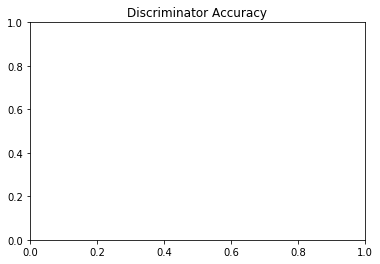

In [22]:
from matplotlib import pyplot as plt

plt.title('Discriminator Loss')
plt.plot(d_loss_means)
plt.savefig('/coco2017/results/discriminator_loss-prp-100epochs.png')
plt.show()
put_object('/coco2017/results/discriminator_loss-prp-100epochs.png', 'd_loss-100epochs')


plt.title('Discriminator Accuracy')
plt.plot(d_acc_means)
plt.savefig('/coco2017/results/discriminator_acc-prp-100epochs.png')
plt.show()
put_object('/coco2017/results/discriminator_acc-prp-100epochs.png', 'd_acc-100epochs')

plt.title('Adversarial Loss')
plt.plot(a_loss_means)
plt.savefig('/coco2017/results/adversarial_loss-prp-100epochs.png')
plt.show()
put_object('/coco2017/results/adversarial_loss-prp-100epochs.png', 'adv_loss-100epochs')

plt.title('Text To Image Loss')
plt.plot(t_loss_means)
plt.savefig('/coco2017/results/text2img_loss-prp-100epochs.png')
plt.show()
put_object('/coco2017/results/text2img_loss-prp-100epochs.png', 't2i_loss-100epochs')

plt.title('Classes Loss')
plt.plot(classes_loss_means)
plt.savefig('/coco2017/results/classes_loss-prp-100epochs.png')
plt.show()
put_object('/coco2017/results/classes_loss-prp-100epochs.png', 'classes_loss-100epochs')